# 1. Data

Every problem starts with data....

Obviously there are a multitude of data sets out there. Thus, this tutorial will make use of two data sets: the stylized "International Airline Passengers" data set as well as a self generated data set of stock prices download from Yahoo! Finance.

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

## 1.1 Working with Data (Structures)

The <code>pandas</code> module allows to introduce data management to data. Using the <code>read_csv</code> method the data is strung into a <code>DataFrame</code> object which allows to directly access the data and providing the means for data analysis and transformation. A dataframe is a collection of <code>Series</code> objects.

A much better formatting of the data can be established if additional arguments are specified when importing the data set, for example:
<ul>
<li><strong>header</strong>: include the first row as the header for the <code>DataFrame</code> object</li>
<li><strong>index_col</strong>: set the index column of the DataFrame to the first column of the data set ('month')</li>
<li><strong>parse_dates</strong>: automatically parse dates which will index the DataFrame</li>
<li><strong>sep</strong>: specify the symbol which seperates the values and strings in the data set - in this case it is semi-colon</li>
</ul>

In [3]:
# load passenger data set and safe to DataFrame
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')

In [5]:
# print the first 5 rows of the DataFrame
df.tail()

,n_passengers
month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [6]:
# print the type of an object
type(df)

pandas.core.frame.DataFrame

In [7]:
# print the data type of all columns except for the index column
df.dtypes

n_passengers    int64
dtype: object

In [8]:
# print summary statistics
df.describe()

,n_passengers
count,144.00000
mean,280.29861
std,119.96632
min,104.00000
25%,180.00000
50%,265.50000
75%,360.50000
max,622.00000


Indexes are important in the domain of pandas data transformations and the applicability of prebuilt analytics methods from other libraries.

In [9]:
# list the index of the DataFrame
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

In [14]:
# save the n_passenger column to a new variable, this becomes a Series object
y = df["n_passengers"]

# or
y = df.n_passengers

In [15]:
# print first 5 rows
y.head()

month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: n_passengers, dtype: int64

In [16]:
# print type of the ts object
type(y)

pandas.core.series.Series

In [20]:
# select all entries from the year '1950'
y['1952-01']

month
1952-01-01    171
Name: n_passengers, dtype: int64

## 1.2 Download Historical Data

This is a sample workflow of how to retrieve data directly from the web using the <code>pandas_datareader</code> module to access <strong>stock price data</strong> from the Yahoo! Finance or Google Finance APIs. Yahoo! Finance is up to now the most popular service, and thus it will also be used here.

In [21]:
# define arguments
tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', '^GSPC']
provider = 'yahoo'
start = datetime.datetime(2012, 5, 18)
end = datetime.date(2017, 8, 22)

In [22]:
# ask Yahoo! Finance for data
panel = web.DataReader(tickers, provider, start, end)

In [26]:
print(panel['Adj Close'])

                AAPL      AMZN        FB      GOOG      NFLX      ^GSPC
Date                                                                   
2012-05-17  68.13225 218.36000       nan 309.51193  10.28143 1304.85999
2012-05-18  68.16567 213.85001  38.23000 298.26010   9.99429 1295.21997
2012-05-21  72.13699 218.11000  34.03000 305.07080  10.24857 1315.98999
2012-05-22  71.58306 215.33000  31.00000 298.45880   9.67286 1316.63000
2012-05-23  73.32967 217.28000  32.00000 302.76083  10.27286 1318.85999
2012-05-24  72.65621 215.24000  33.03000 299.87958  10.03857 1320.68005
2012-05-25  72.26680 212.89000  31.91000 293.85376  10.03143 1317.81995
2012-05-29  73.54945 214.75000  28.84000 295.24970   9.92000 1332.42004
...              ...       ...       ...       ...       ...        ...
2017-08-11 157.48000 967.98999 168.08000 914.39002 171.39999 2441.32007
2017-08-14 159.85001 983.29999 170.75000 922.66998 171.00000 2465.84009
2017-08-15 161.60001 982.73999 171.00000 922.21997 168.50000 246

Without further specification, this command returns a <code>Panel</code> object. A panel can be thought of as a collection of <code>DateFrame</code> object. 

Additional data is also provided by this service, such as <strong>corporate actions</strong> like stock split or dividend payments

In [27]:
# ask Yahoo! Finance for data
corporate_actions = web.DataReader(tickers, 'yahoo-actions', start, end)

In [30]:
corporate_actions['GOOG']

KeyError: 'GOOG'

In [31]:
# show corporate actions axes
corporate_actions.axes

[Index(['Stock Splits', 'Dividends'], dtype='object'),
 DatetimeIndex(['2012-08-09', '2012-11-07', '2013-02-07', '2013-05-09',
                '2013-08-08', '2013-11-06', '2014-02-06', '2014-03-27',
                '2014-05-08', '2014-06-09', '2014-08-07', '2014-11-06',
                '2015-02-05', '2015-04-27', '2015-05-07', '2015-07-15',
                '2015-08-06', '2015-11-05', '2016-02-04', '2016-05-05',
                '2016-08-04', '2016-11-03', '2017-02-09', '2017-05-11',
                '2017-08-10'],
               dtype='datetime64[ns]', name='Date', freq=None),
 Index(['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', '^GSPC'], dtype='object')]

In [32]:
corporate_actions.loc['Stock Splits', '2012' ,'AAPL']

Date
2012-08-09    NaN
2012-11-07    NaN
Name: AAPL, dtype: object

To get the adjusted prices only, that is, prices that are corrected for dividend payments such that there are no jumps or breaks in the stock time series. Using the <code>loc</code> selector a column element across all included dataframes can be selected

In [33]:
# get adjusted closing prices from all data series
# this reduces the Panel to a DataFrame
adj_close = panel.loc['Adj Close']

# get all weekdays between 18.05.2012 and 22.08.2017
all_weekdays = pd.date_range(start=start, end=end, freq='B')

# adjust the DataFrame index to be only the weekdays
adj_close = adj_close.reindex(all_weekdays)

# after reindexing we have to amend for missing values
adj_close = adj_close.fillna(method='ffill')

In [35]:
# have a look at what we have created
adj_close.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999
2012-05-24,72.65621,215.24000,33.03000,299.87958,10.03857,1320.68005


In [36]:
type(adj_close)

pandas.core.frame.DataFrame

## 1.3 Build a stock price data set

The <code>Panel</code> object we created earlier contains much more that then we actually need for this notebook. Thus, we can use a more elegant way to can exaclty the data that we want

In [39]:
# ask Yahoo! Finance for data and save to DataFrame
data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']

# save data to a .csv
data.to_csv('./data/stock_data.csv', sep=';')

# show the data
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
2012-05-17,68.13225,218.36000,nan,309.51193,10.28143,1304.85999
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999


In [40]:
# import data from a .csv
data = pd.read_csv('./data/stock_data.csv', header=0, sep=';', parse_dates=True, index_col=0)

# rearrange data to only show week days
all_weekdays = pd.date_range(start=start, end=end, freq='B')
data = data.reindex(all_weekdays)

# after reindexing we have to amend for missing values
data = data.fillna(method='ffill')
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999
2012-05-24,72.65621,215.24000,33.03000,299.87958,10.03857,1320.68005


How many working days are there in a year?

In [41]:
# the actual length of one year of working days 365 - 2 * 52
len(pd.date_range(start=datetime.datetime(2012, 5, 18), end=datetime.datetime(2013, 5, 18), freq='B'))

261

## 1.4 Data visualization

Main tools for plotting in this Notebook are the libraries <code>matplotlib</code>, which contains a lot of the functionalities available in MathLab without the interface, and <code>seaborn</code>.

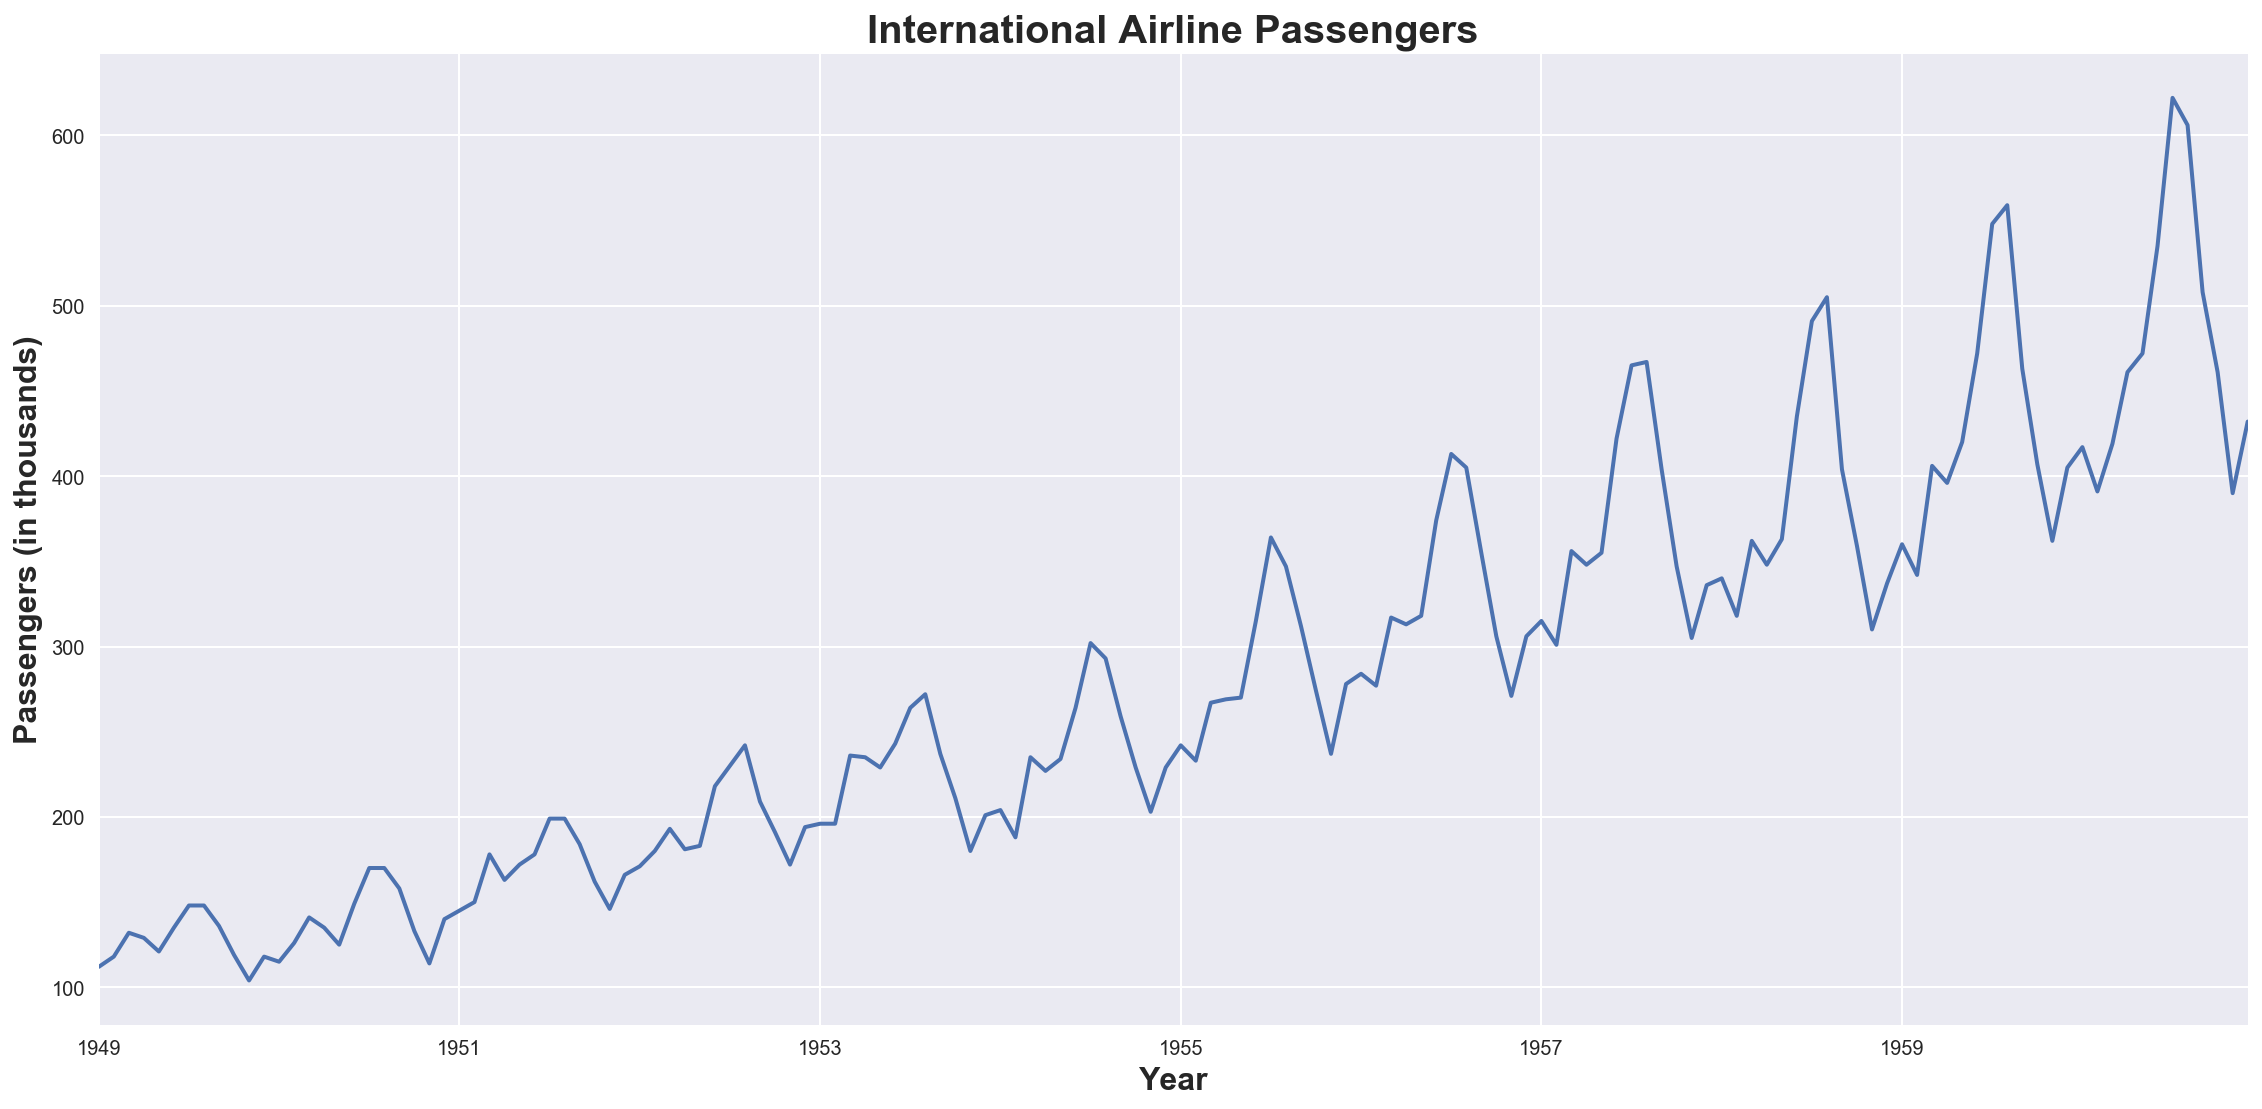

In [44]:
# initialize figure and axis
fig, ax = plt.subplots();

# plot resampled series
df['n_passengers'].plot(ax=ax);

# style the plot
ax.set_title('International Airline Passengers');
ax.set_ylabel('Passengers (in thousands)');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();

# show the plot
plt.show()

There appears to be some kind trend component included in this time series. 

By using the <code>resample</code> method on the <code>DataFrame</code> object (the time series) with  argument <code>'AS'</code> a new time series is constructed. The series as it is resampled is offest at the beginning of each year. By summing the resampled values we can see a steady increase of total passengers over the years.

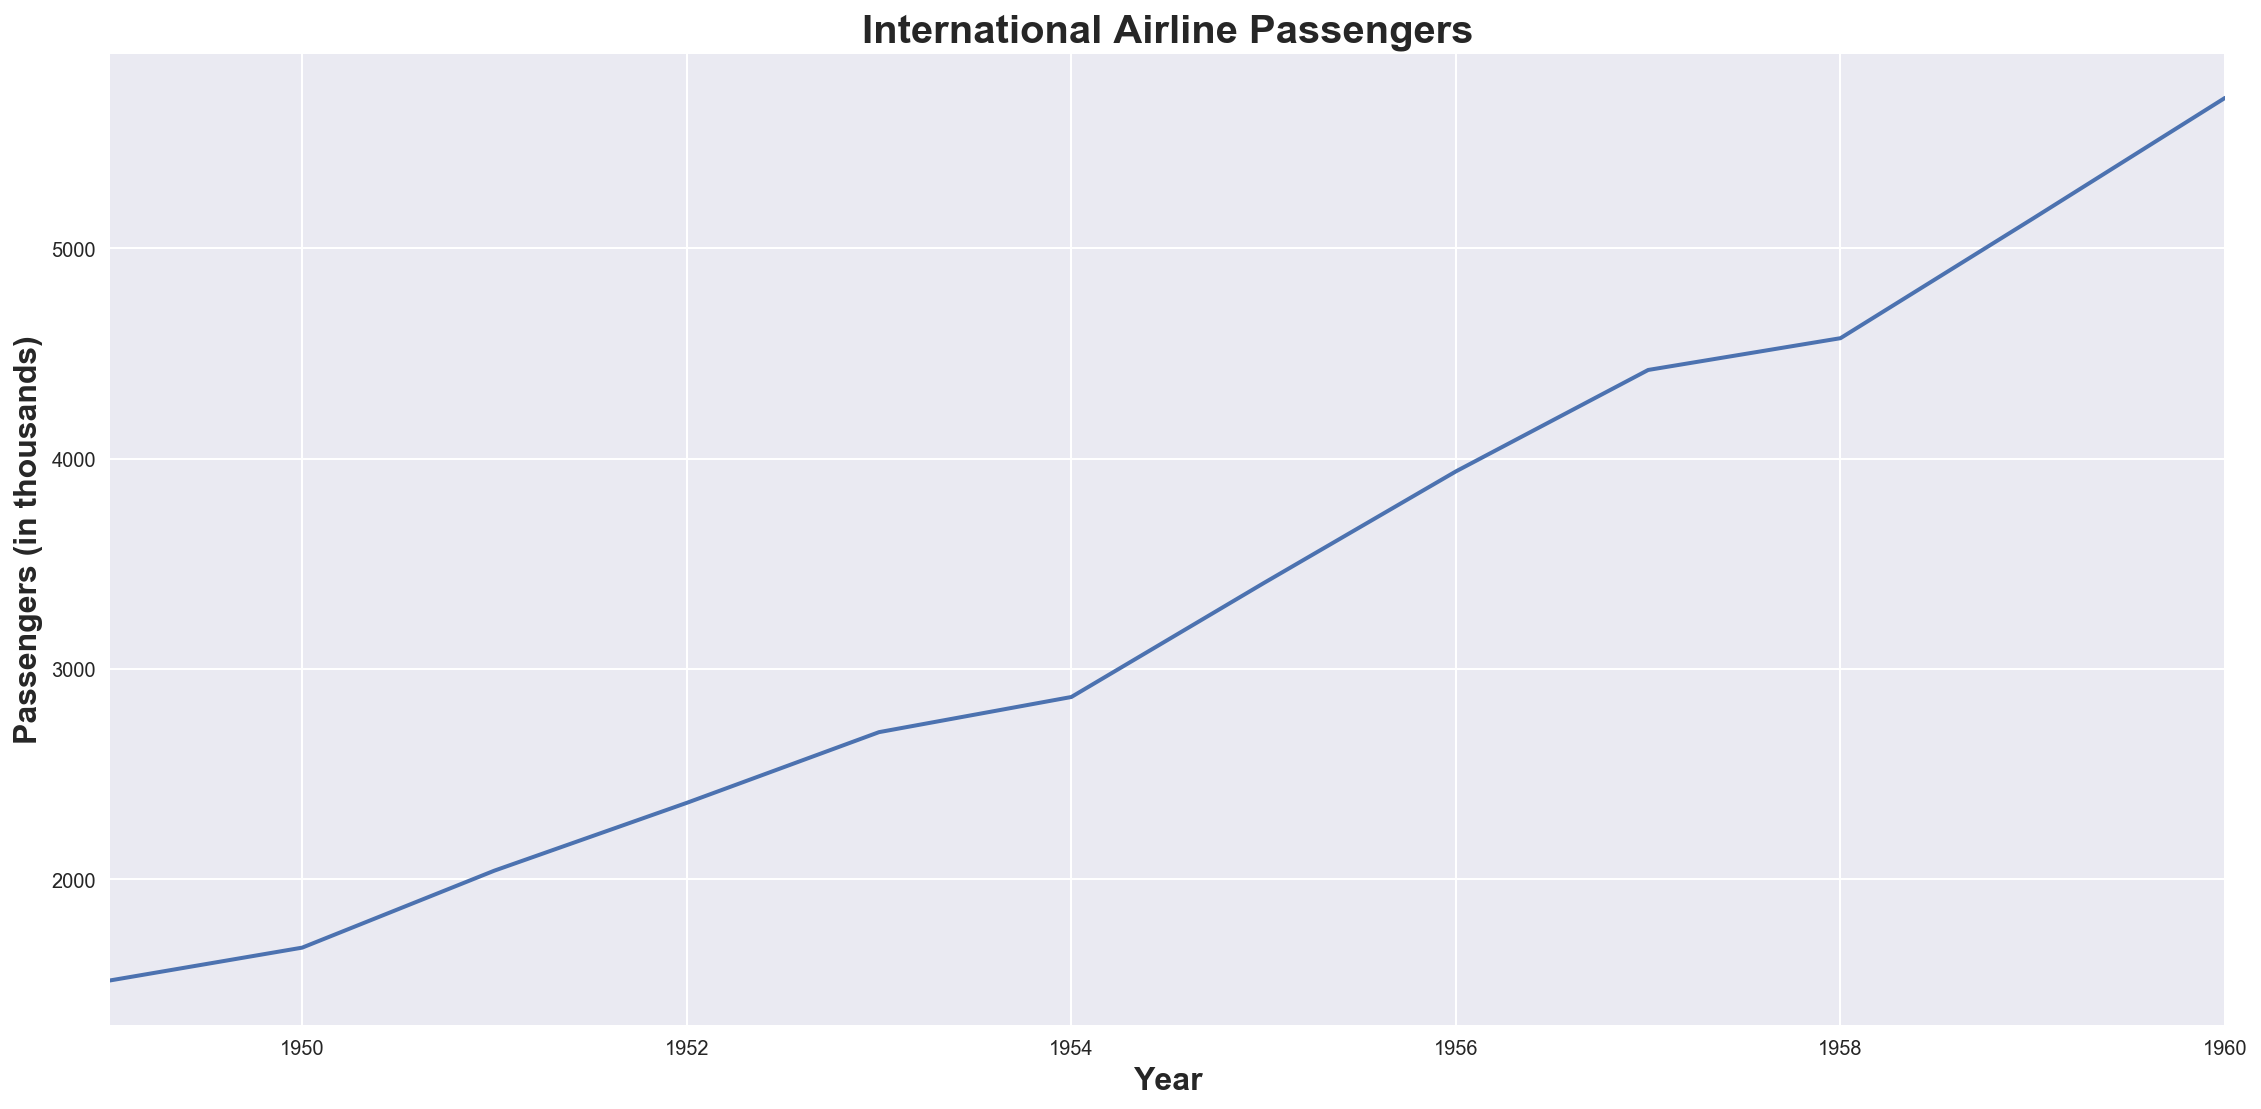

In [47]:
# initialize figure and axis
fig, ax = plt.subplots();

# plot resampled series
df['n_passengers'].resample('AS').sum().plot(ax=ax)

# style the plot
ax.set_title('International Airline Passengers', fontweight='bold');
ax.set_ylabel('Passengers (in thousands)');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();

# show the plot
plt.show()

## 1.5 Exercise

Import the earlier created stock prices data set and save it in a formatted fashion to a variable called <code>stock</code>. You may want to use import arguments. It can be found in the <code>./data/raw_data.csv</code> in your corresponding path. Have a look at the top rows and print the summary statistics. 

In [48]:
df = pd.read_csv('./data/raw_data.csv', header=0, sep=';', parse_dates=True, index_col=0)

In [49]:
df.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
2012-05-17,68.13225,218.36000,nan,310.36169,10.28143,1304.85999
2012-05-18,68.16567,213.85001,38.23000,299.07898,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.90839,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,299.27823,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,303.59207,10.27286,1318.85999


Asign the Apple stock time series to a <code>Series</code> object named <code>ts</code> and plot it

In [52]:
y = df['AAPL']
y

Date
2012-05-17    68.13225
2012-05-18    68.16567
2012-05-21    72.13699
2012-05-22    71.58306
2012-05-23    73.32967
2012-05-24    72.65621
2012-05-25    72.26680
2012-05-29    73.54945
                ...   
2017-08-11   157.48000
2017-08-14   159.85001
2017-08-15   161.60001
2017-08-16   160.95000
2017-08-17   157.86000
2017-08-18   157.50000
2017-08-21   157.21001
2017-08-22   159.78000
Name: AAPL, Length: 1325, dtype: float64

Open the data folder and have a look at the other data sets. Your are free to explore these as well. Is there anything peculiar about the <code>temp_ger.csv</code> data set?

In [53]:
df = pd.read_csv('./data/temp_ger.csv', parse_dates=True, header=0, sep=';', index_col=0)

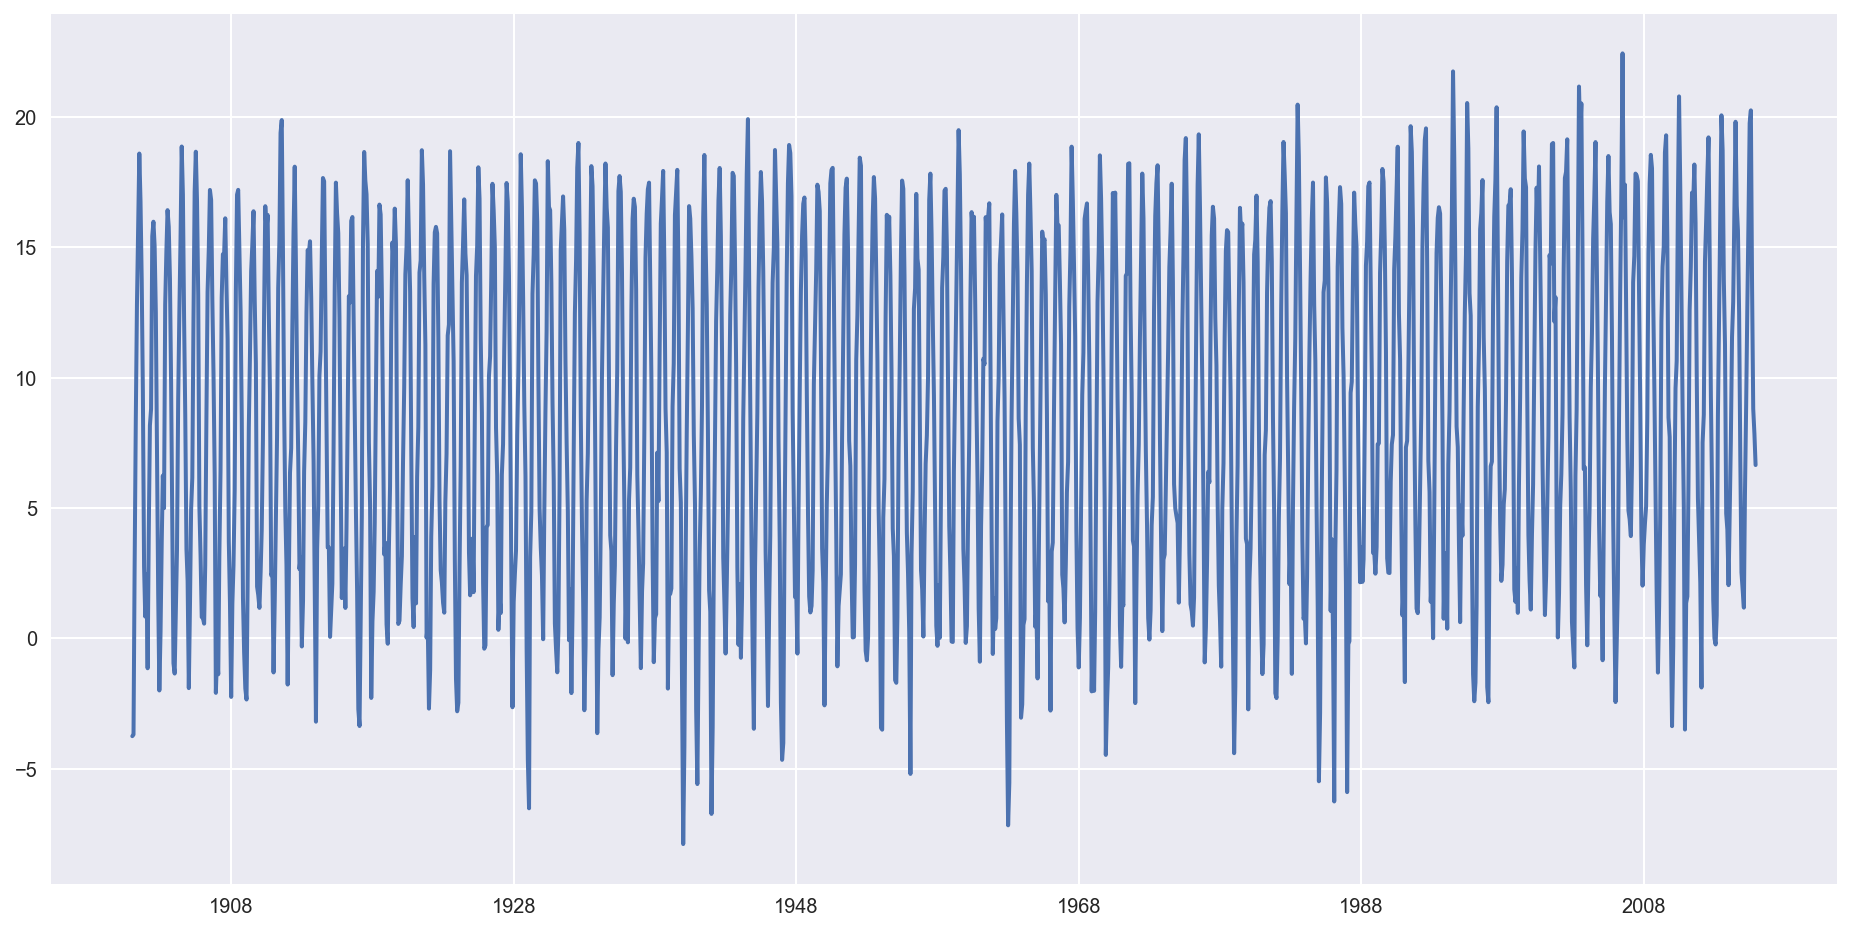

In [54]:
plt.plot(df)
